Notebook to create plots for displaying in illustrator

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
import re
# plt.rcParams['font.size'] = 16

In [2]:
# Load in thalamus dataset
thData = sc.read("../Data/thData.h5ad")

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


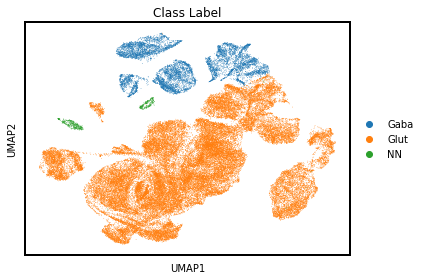

In [3]:
# Class UMAP plot
ax = sc.pl.umap(thData, color="class_label",show=False)
ax.figure.set_size_inches(6,4)
plt.tight_layout()
ax.set_rasterized(True)
# plt.xlabel('UMAP1', fontsize=16)
# plt.ylabel('UMAP2', fontsize=16)
plt.title('Class Label')
plt.setp(ax.spines.values(), linewidth=2)
# plt.legend(["","Gaba","Glut","NN"],fontsize=16)
plt.savefig("../Figures/Panels/Class_UMAP.pdf", dpi=120, transparent=True)

In [49]:
# function to create a mask dictionary for umap plotting
def create_mask_dict(dataObj):
    """ Function to create a mask dictionary for subclass plotting, where glutamatergic 
     subclasses have color labels, while other classes are grayed out """
    import matplotlib.colors
    names = dataObj.obs["subclass_label"].unique() 
    mask_dict = {}
    for name in names:
        if name in ["Endo", "Astro", "TH/HY Gata3", "HY/TH Gnb3", "TH/HY Pax6", "TH Otx2", "HY Lhx1"]:
            mask_dict[name] = matplotlib.colors.to_rgb("#D3D3D3")
        else:
            mask_dict[name] = matplotlib.colors.to_rgb(dataObj[dataObj.obs.subclass_label == name].obs["subclass_color"].unique()[0])
    return mask_dict

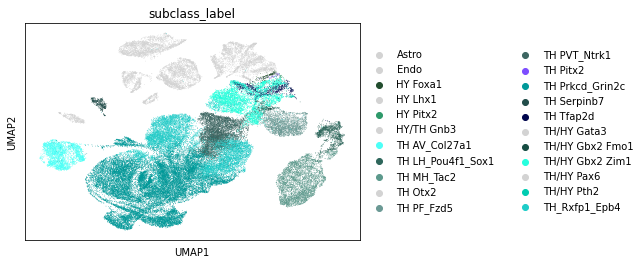

In [50]:
color_dict = create_mask_dict(thData)
sc.pl.umap(thData, color = "subclass_label",palette = color_dict)
# color_dict


## Potential poster plots
Specify color of umaps
https://scanpy.discourse.group/t/specifying-color-of-umap-cluster/538/2

In [9]:
classDict

{'Gaba': ['TH/HY Gata3', 'TH/HY Pax6', 'HY/TH Gnb3', 'HY Lhx1', 'TH Otx2'],
 'Glut': ['HY Foxa1',
  'TH PVT_Ntrk1',
  'TH/HY Pth2',
  'TH LH_Pou4f1_Sox1',
  'TH/HY Gbx2 Fmo1',
  'TH MH_Tac2',
  'TH Serpinb7',
  'TH_Rxfp1_Epb4',
  'TH/HY Gbx2 Zim1',
  'HY Pitx2',
  'TH AV_Col27a1',
  'TH Pitx2',
  'TH Tfap2d',
  'TH PF_Fzd5',
  'TH Prkcd_Grin2c'],
 'NN': ['Astro', 'Endo']}

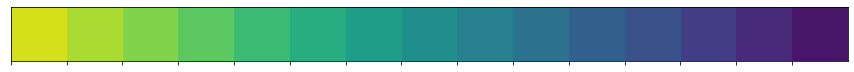

In [13]:
# Have a combination of manually annotated colors and seaborn blending

# Want to create a dictionary of each subclass contained within a given class
# First create unique tuples with each class and subclass pair
groupPairs = set(zip(thData.obs["class_label"],thData.obs["subclass_label"]))

# Then initialize a dictionary where each class is a key corresponding to an empty list
classDict = {pair[0]: [] for pair in groupPairs}

# Add each subclass to the corresponding class list
for pair in groupPairs:
    classDict[pair[0]].append(pair[1])
    
# Create a dictionary where each subclass corresponds to a color
colorDict = {}
colorCount = 0

rgb = ['rebeccapurple','gold','forestgreen','steelblue','navy']
# colorBlend = sns.blend_palette(rgb, n_colors=len(classDict["Glut"]))
colorBlend = sns.color_palette("viridis_r", n_colors=len(classDict["Glut"]))
sns.palplot(colorBlend)

for pair in groupPairs:
    
    # Manually assign non-neuronal as light gray
    if pair[1] in classDict["NN"]:
        colorDict[pair[1]] = "lightgray"
        
    # Manually assign non-neuronal as dark gray
    elif pair[1] in classDict["Gaba"]:
        colorDict[pair[1]] = "dimgray"
    
    # Assign glutamatergic subclasses a value from blended palette
    else:
        colorDict[pair[1]] = colorBlend[colorCount]
        colorCount += 1

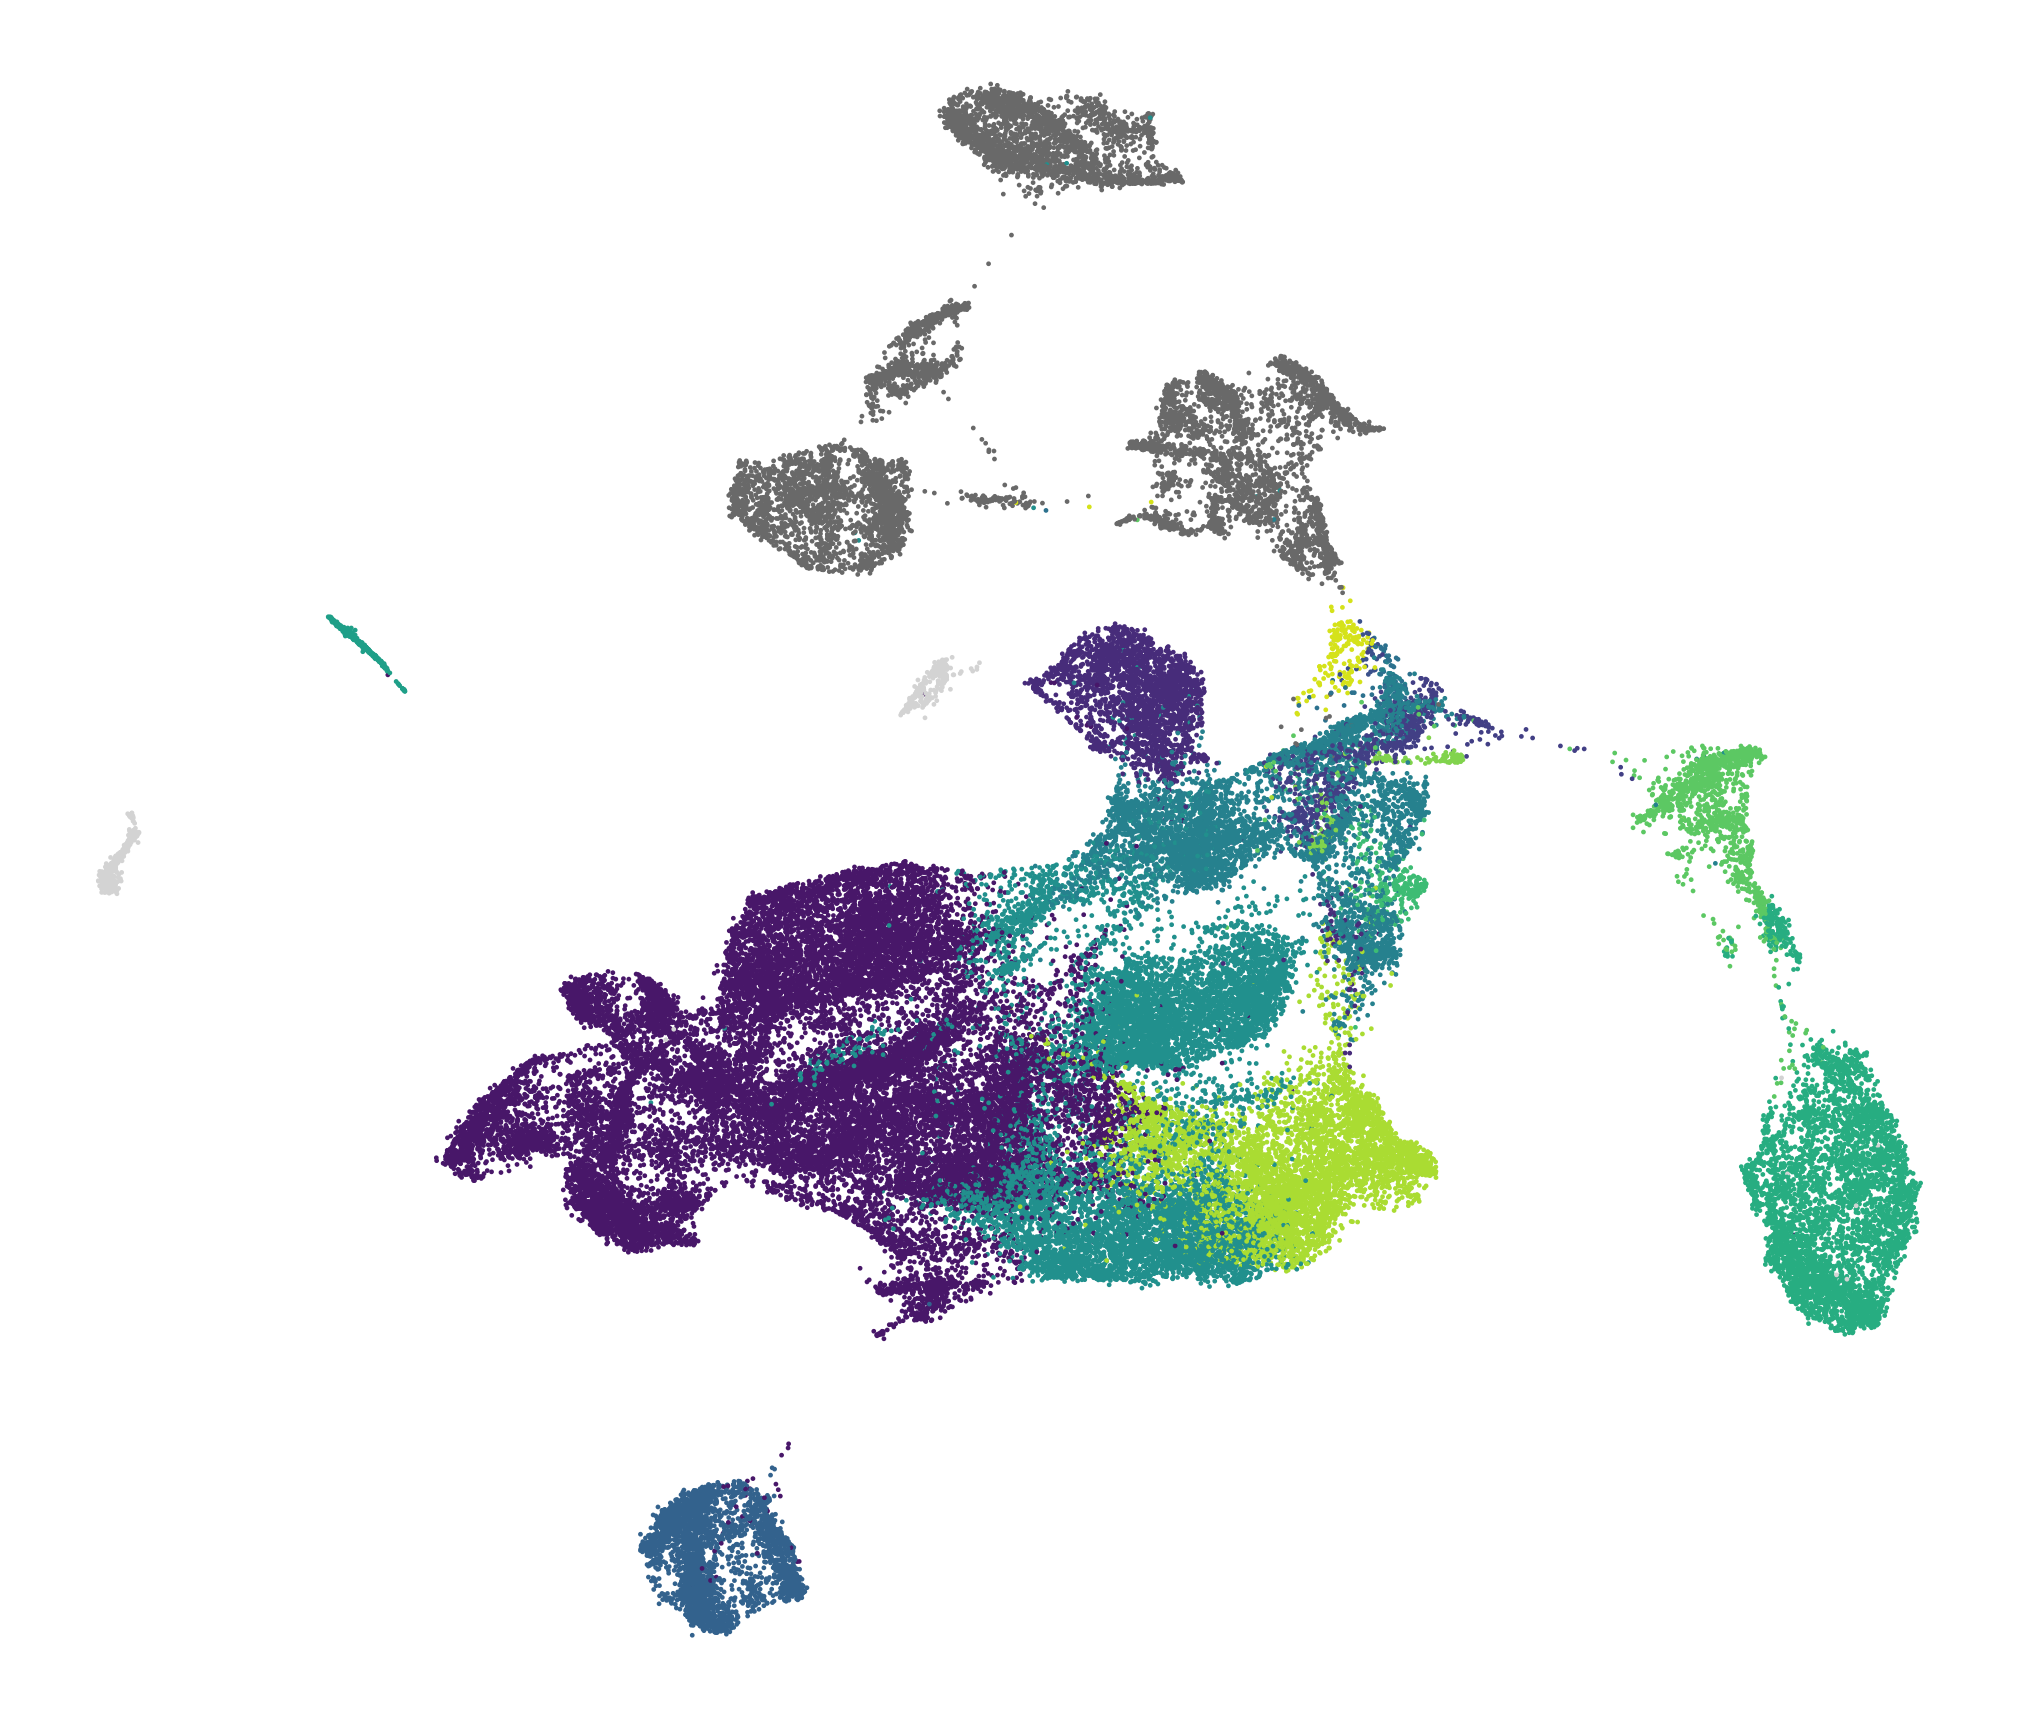

In [14]:
# sc.tl.umap(thData,spread = .4, min_dist = 0.2) #.4, .2
ax = sc.pl.umap(thData, color="subclass_label",palette = colorDict,show=False, size = 90)
ax.figure.set_size_inches(32,24)
# ax = sc.pl.umap(thData, color="subclass_label",palette = colorDict,show=False, size = 70)
# ax.figure.set_size_inches(32,32)
ax.axis('off')
plt.title('')
plt.tight_layout()
ax.get_legend().remove()

## DE glu genes

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


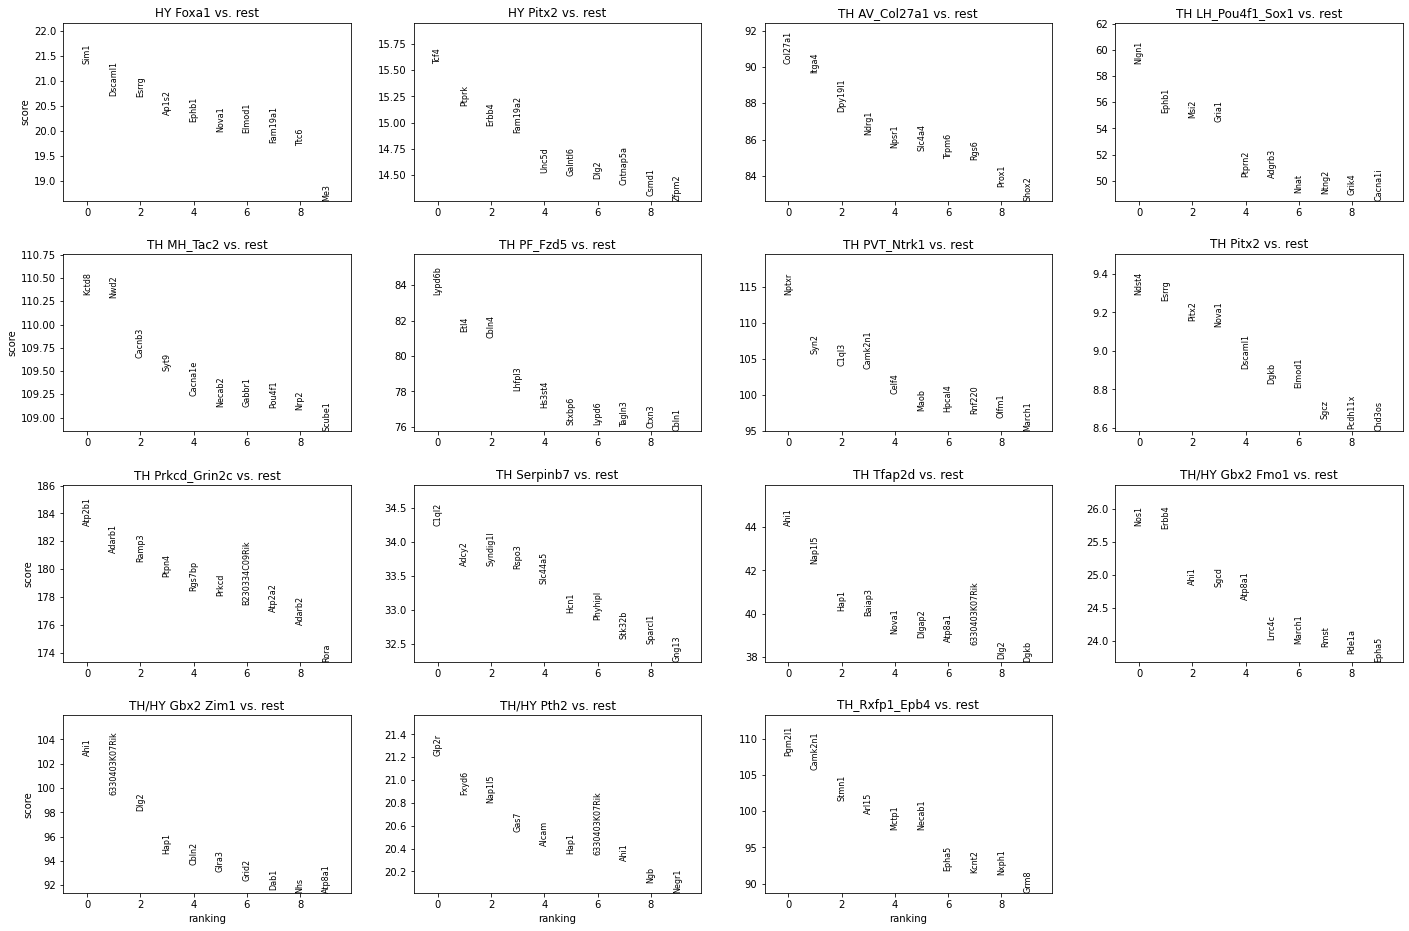

In [32]:
# Index by cell class
gluData = thData[thData.obs.class_label == "Glut"]
# Rank differentially expressed genes by comparing subclasses to all other subclass clusters
sc.tl.rank_genes_groups(gluData, 'subclass_label', method='wilcoxon',pts=True)
sc.pl.rank_genes_groups(gluData, n_genes=10, sharey=False)

In [ ]:
sc.pl.dotplot(gluData,["Foxa1", "Col27a1", "Sgcd","Otx2"],"subclass_label", dendrogram = True)

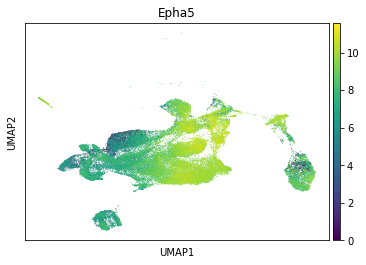

In [31]:
sc.pl.umap(gluData,color="Epha5")

## Roi plots

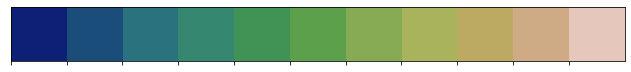

In [23]:
# Have a combination of manually annotated colors and seaborn blending

# Use regexp to find TH labeled regions
p  = re.compile('TH', re.IGNORECASE)
allROIs = thData.obs["roi"].unique()
roiList = list(filter(p.search, allROIs))

# Create a dictionary where each subclass corresponds to a color
colorDict = {}
colorCount = 0

# Create a colormap of equal length to list of desired ROIs
colorBlend = sns.color_palette("gist_earth", n_colors=len(roiList))
# colorBlend = sns.color_palette("Spectral", n_colors=len(roiList))
sns.palplot(colorBlend)

# Assign each roi type a color
for roi in allROIs:
    
    if roi == "TH":
        colorDict[roi] = 'gray'
        
    # Assign TH as varying shades of colormap
    elif roi in roiList:
        colorDict[roi] = colorBlend[colorCount]
        colorCount += 1
        
    # Manually assign non-TH as black
    else:
        colorDict[roi] = "black"

In [5]:
# Remove "broadly labeled" TH roi cells
x = thData[thData.obs["roi"] != "TH"]
for name in x.obs["roi"].unique():
    print(name)

TH - RE-RH-CM-IAM-SMT-PR-Xi
TH - MG-SPFp-PP-POL-SGN-PoT-PIL
RSP
HIP
PL-ILA-ORB
PAR-POST-PRE-SUB-ProS
AI-CLA
ACA
HIP - CA
ENT
AUD-TEa-PERI-ECT
MB - PRT
TH - PVT-PT
STR - LSX
TH - MH-LH-LP
MB - PAG-RAmb
TH - MD-IMD-PCN-CL
STR - sAMY
TH - PF-SPA-SPFm-VPMpc-VPLpc-RT
MB - MRN-CUN-RN-RR-PPN-PRT-SC-IC
MB - MRN-CUN-RN-RR-PPN-NB-SAG-PBG
TH - VAL-VPM-VPL-VM
TH - PO-Eth
HY LZ
MB - MRN-CUN-RN-RR-PPN-PRT
TH - AD-AV-AM-IAD-LD
CNU - PAL
TH - LGd-IGL-LGv
HY - HYml
HY - HYmm
HY - HYa1
HY - HYm2
HY -  MEZ-PVZ-PVR
MY - SPVC-SPVI-SPVO
MY - AP-DCO-VCO-DCN-ECU-NTS
MY - CN-DCN-ECU-NTS-SPVC-SPVI-SPVO
CTXsp - CLA-EP-LA-BLA-BMA-PA
CB - VERM
CB - HEM
HY - HYa2
HY - HYpm
HY - HYpl
MB - VTA-SN
MB - SC
MB - MRN-CUN-RN-RR-PN
MY - MYsat-Mymot-vent ant
OLF - MOB-AOB
PONS - Psen
PONS - Pmot-Psat ant
PONS - Pmot-Psat post
STR - STRd
CB - VERM-CBN
MB - SC-IC
MO-FRP
MY - MYsat-MYmot ant
MY - MYsat-MYmot post
OLF - AON-TT-DP-PIR-COA-NLOT-PAA-TR
VIS-PTLp
MY - MYsat-MYmot


C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


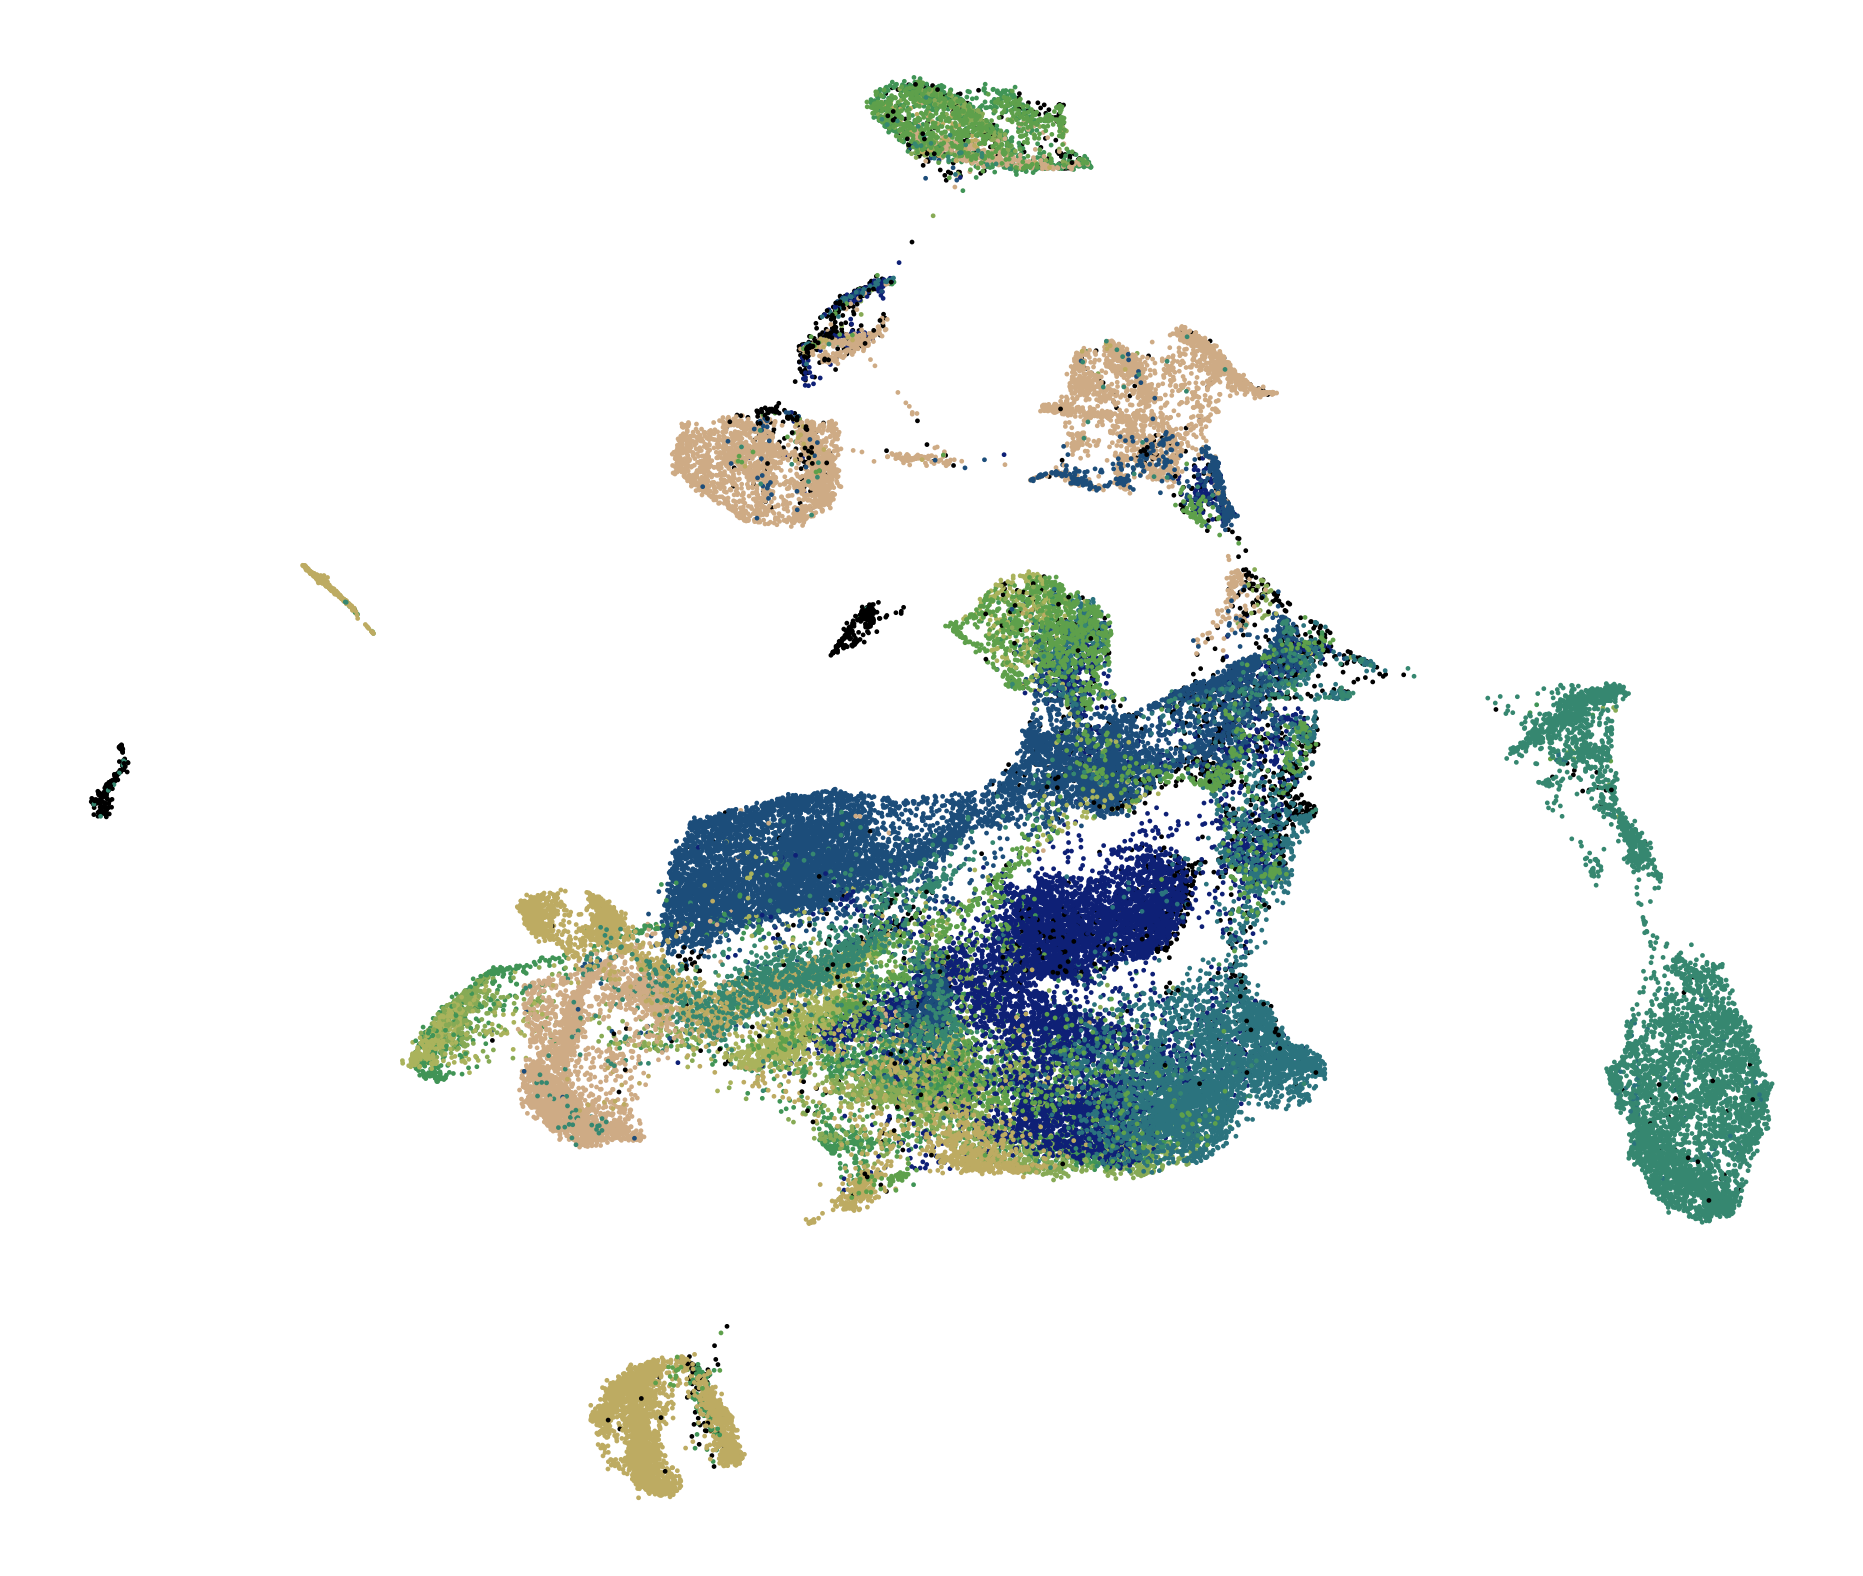

In [24]:
# Remove "broadly labeled" TH roi cells
x = thData[thData.obs["roi"] != "TH"]
# sc.tl.umap(thData,spread = .4, min_dist = 0.2) #.4, .2
ax = sc.pl.umap(x, color="roi",palette = colorDict,show=False, size = 90,legend_fontsize='xx-large')
ax.figure.set_size_inches(42,22)
# ax = sc.pl.umap(thData, color="subclass_label",palette = colorDict,show=False, size = 70)
# ax.figure.set_size_inches(32,32)
ax.axis('off')
plt.title('')
plt.tight_layout()
ax.get_legend().remove()

In [25]:
# Look at count for each region in Prkcd subclass
gluTypes = thData.obs.subclass_label.unique()
gluCounts = pd.DataFrame([sum(thData.obs.subclass_label == name) for name in gluTypes], columns= ["Count"], index = gluTypes)
gluCounts = gluCounts.sort_values(by = "Count", ascending=False)
gluCounts

Count
TH Prkcd_Grin2c    23362
TH_Rxfp1_Epb4      10411
TH PVT_Ntrk1        5419
TH/HY Gbx2 Zim1     5006
TH MH_Tac2          4405
TH/HY Gata3         3077
TH AV_Col27a1       3011
TH PF_Fzd5          2500
HY/TH Gnb3          2392
TH/HY Pax6          1957
TH LH_Pou4f1_Sox1   1346
TH Otx2              987
TH Tfap2d            774
Astro                399
TH Serpinb7          398
HY Lhx1              376
Endo                 279
TH/HY Gbx2 Fmo1      248
TH/HY Pth2           170
HY Foxa1             170
HY Pitx2              83
TH Pitx2              30

## Prkcd subset roi labeling

In [6]:
# Subindex to prkcd
prkcdData = thData[thData.obs.subclass_label == "TH Prkcd_Grin2c"]

In [7]:
# Look at count for each region in Prkcd subclass
gluTypes = prkcdData.obs.roi.unique()
gluCounts = pd.DataFrame([sum(prkcdData.obs.roi == name) for name in gluTypes], columns= ["Count"], index = gluTypes)
gluCounts = gluCounts.sort_values(by = "Count", ascending=False)
gluCounts

Count
TH - MG-SPFp-PP-POL-SGN-PoT-PIL     5645
TH                                  4520
TH - LGd-IGL-LGv                    3110
TH - AD-AV-AM-IAD-LD                2482
TH - MD-IMD-PCN-CL                  1627
TH - RE-RH-CM-IAM-SMT-PR-Xi         1460
TH - VAL-VPM-VPL-VM                 1332
TH - MH-LH-LP                       1319
TH - PO-Eth                         1114
TH - PF-SPA-SPFm-VPMpc-VPLpc-RT      458
MB - PRT                             133
TH - PVT-PT                           48
STR - LSX                             47
HY LZ                                 17
MB - MRN-CUN-RN-RR-PPN-PRT            13
HY - HYml                             12
CNU - PAL                             11
HY - HYa1                              6
HY - HYm2                              6
MB - MRN-CUN-RN-RR-PPN-NB-SAG-PBG      1
MB - MRN-CUN-RN-RR-PPN-PRT-SC-IC       1

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


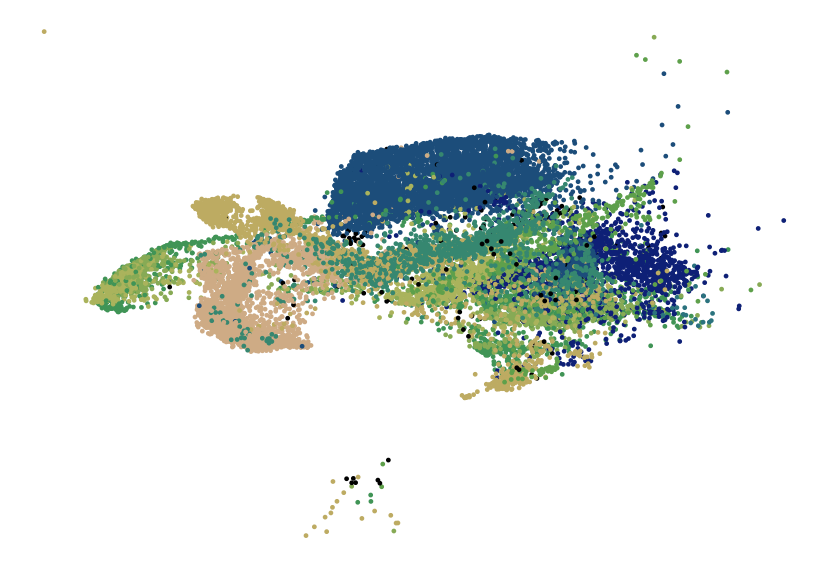

In [216]:
# Plot PRKCD subsetted roi data
minusTH = prkcdData[prkcdData.obs["roi"] != "TH"]
ax = sc.pl.umap(minusTH, color='roi',palette = colorDict, show = False, size = 90)
ax.figure.set_size_inches(18,8)
ax.axis('off')
plt.title('')
plt.tight_layout()
ax.get_legend().remove()

In [13]:
minusTH.obs["roi"].unique()
prkcdROIs = list(filter(p.search, minusTH.obs["roi"].unique()))
len(prkcdROIs)

10

In [15]:
# Look at count for each region in Prkcd subclass
gluCounts = pd.DataFrame([sum(prkcdData.obs.roi == name) for name in prkcdROIs], columns= ["Count"], index = prkcdROIs)
gluCounts = gluCounts.sort_values(by = "Count", ascending=False)
gluCounts

Count
TH - MG-SPFp-PP-POL-SGN-PoT-PIL   5645
TH - LGd-IGL-LGv                  3110
TH - AD-AV-AM-IAD-LD              2482
TH - MD-IMD-PCN-CL                1627
TH - RE-RH-CM-IAM-SMT-PR-Xi       1460
TH - VAL-VPM-VPL-VM               1332
TH - MH-LH-LP                     1319
TH - PO-Eth                       1114
TH - PF-SPA-SPFm-VPMpc-VPLpc-RT    458
TH - PVT-PT                         48

## Prkcd subclass re-embed UMAP

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


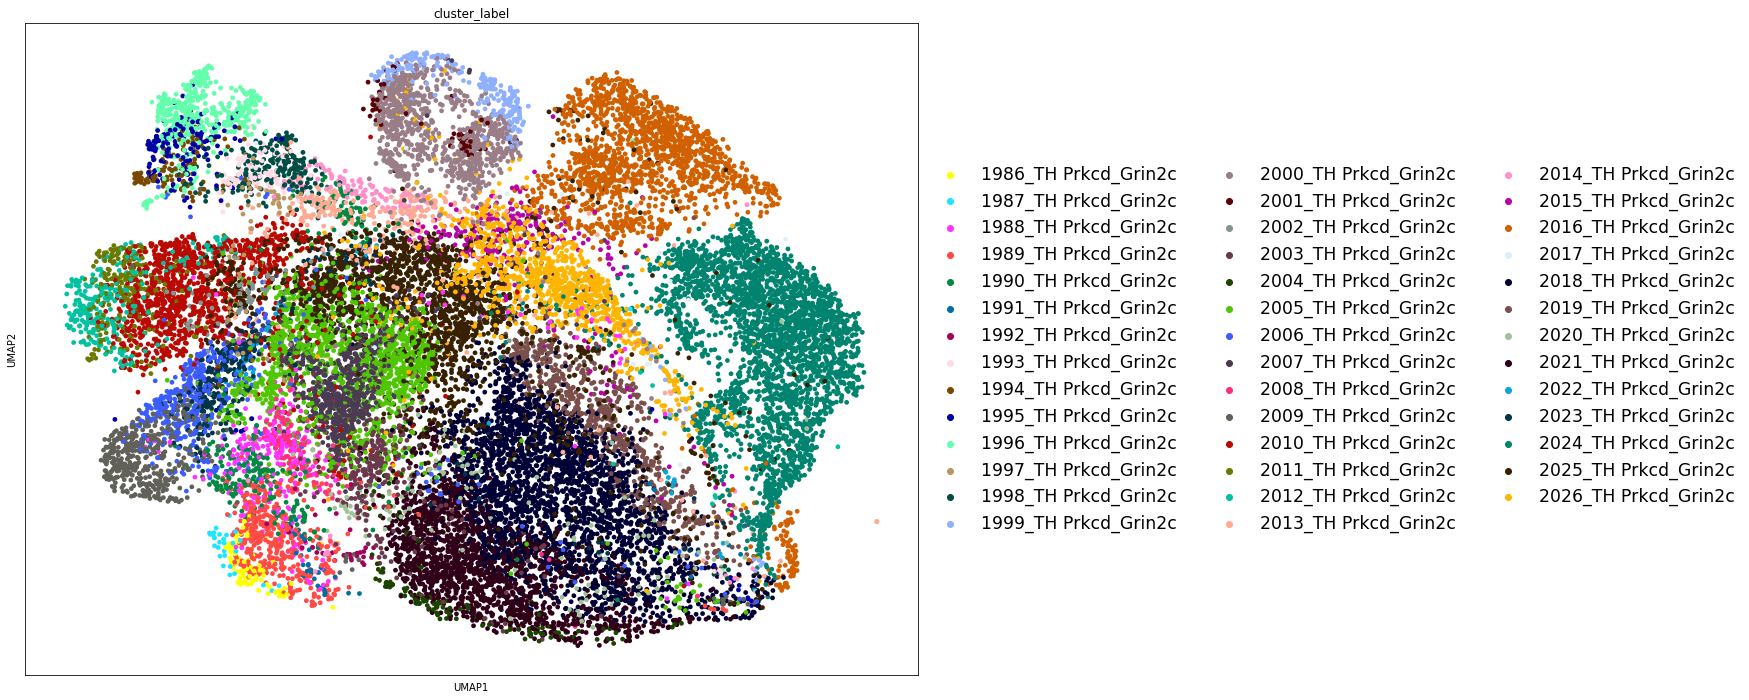

In [13]:
# embedData = prkcdData.copy()
sc.tl.umap(embedData) #spread = .4, min_dist = 0.2 #.4, .2
ax = sc.pl.umap(embedData, color="cluster_label",show=False, size = 90,legend_fontsize = "xx-large")
ax.figure.set_size_inches(16,12)
# ax.figure.set_size_inches(32,24)
# ax = sc.pl.umap(thData, color="subclass_label",palette = colorDict,show=False, size = 70)
# ax.figure.set_size_inches(32,32)
# ax.axis('off')
# plt.title('')
# plt.tight_layout()
# ax.get_legend().remove()

## Prkcd subclass pca

In [5]:
# Subindex to prkcd
prkcdData = thData[thData.obs.subclass_label == "TH Prkcd_Grin2c"]

# Filter out undesired genes
# outGenes = ["B530045E10Rik","Hhatl","Dhrs3"]
# keepGenes = list(set(prkcdData.var_names) - set(outGenes))
# prkcdData = prkcdData[:,keepGenes]

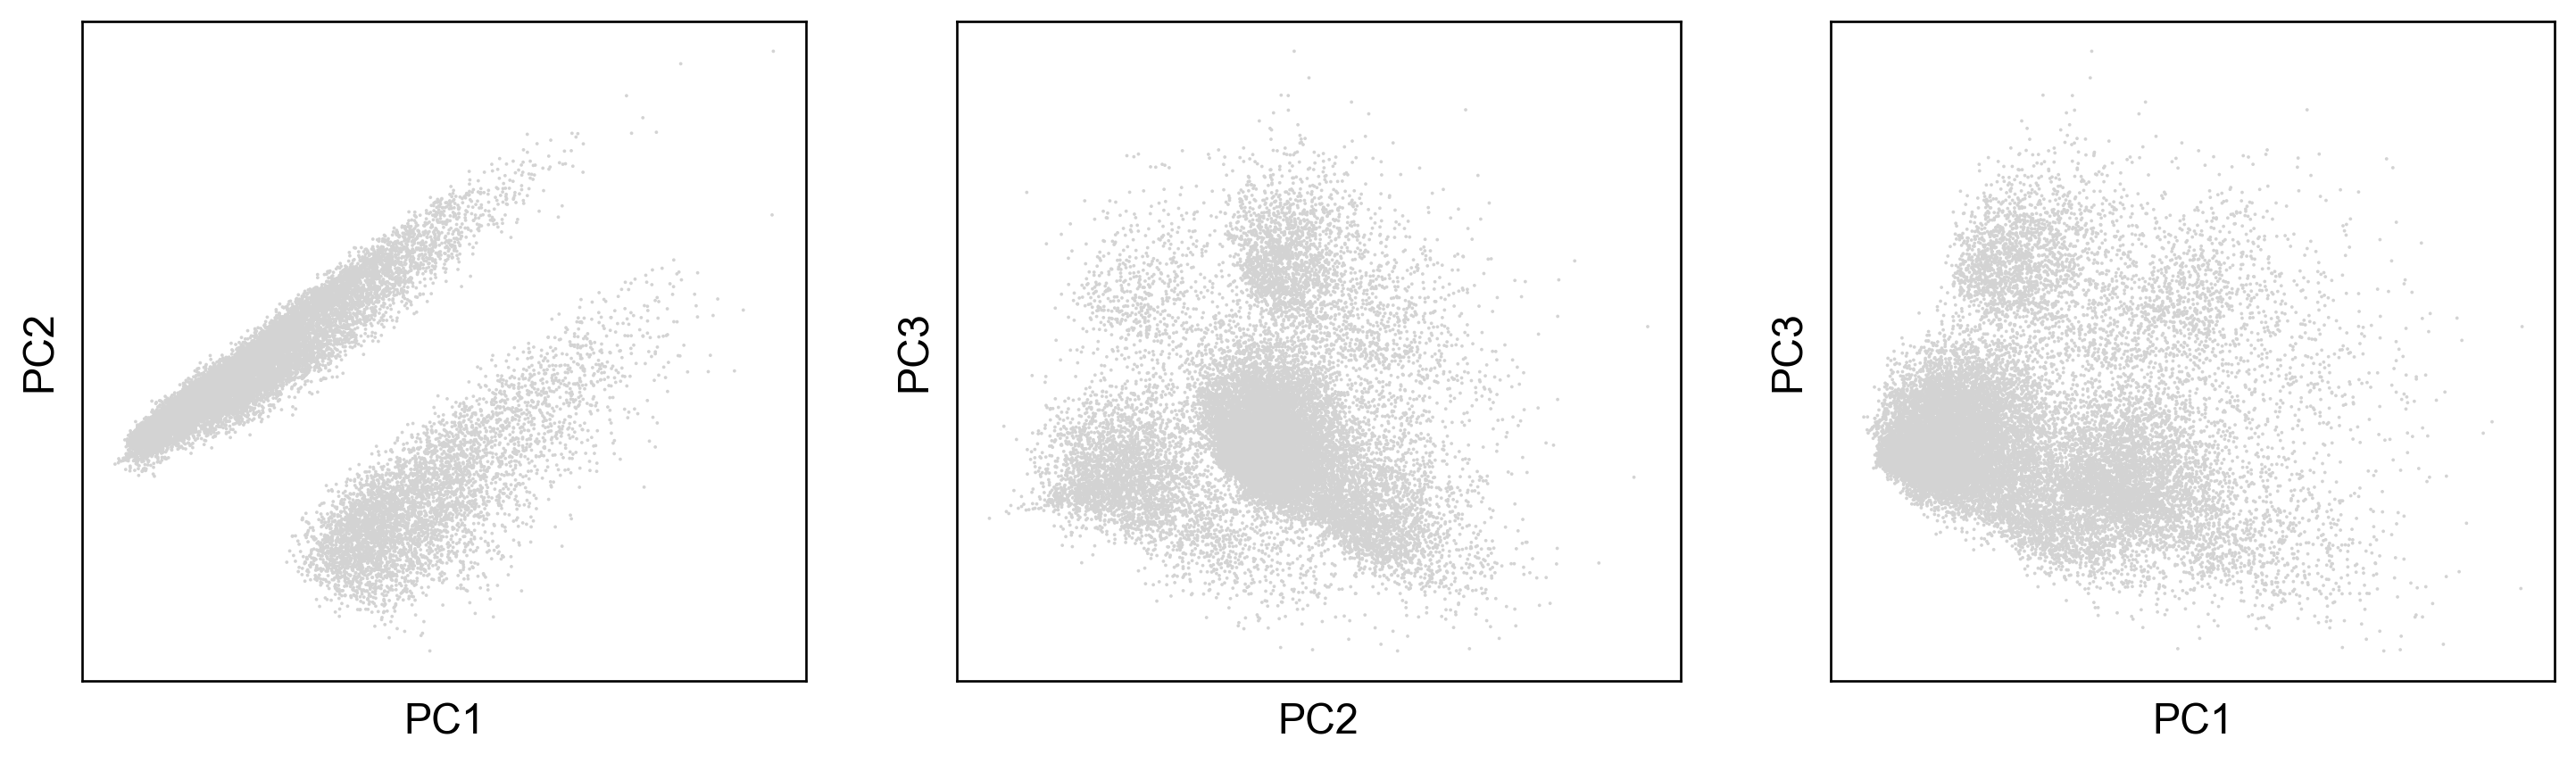

In [147]:
# Plot PCA
sc.tl.pca(prkcdData)
sc.set_figure_params(dpi=120)
sc.pl.pca(prkcdData, dimensions = [(0,1),(1,2),(0,2)])
# genes = ["B530045E10Rik","Hhatl","Dhrs3"]
# sc.pl.pca(prkcdData, components = ['1,2'], color=genes)

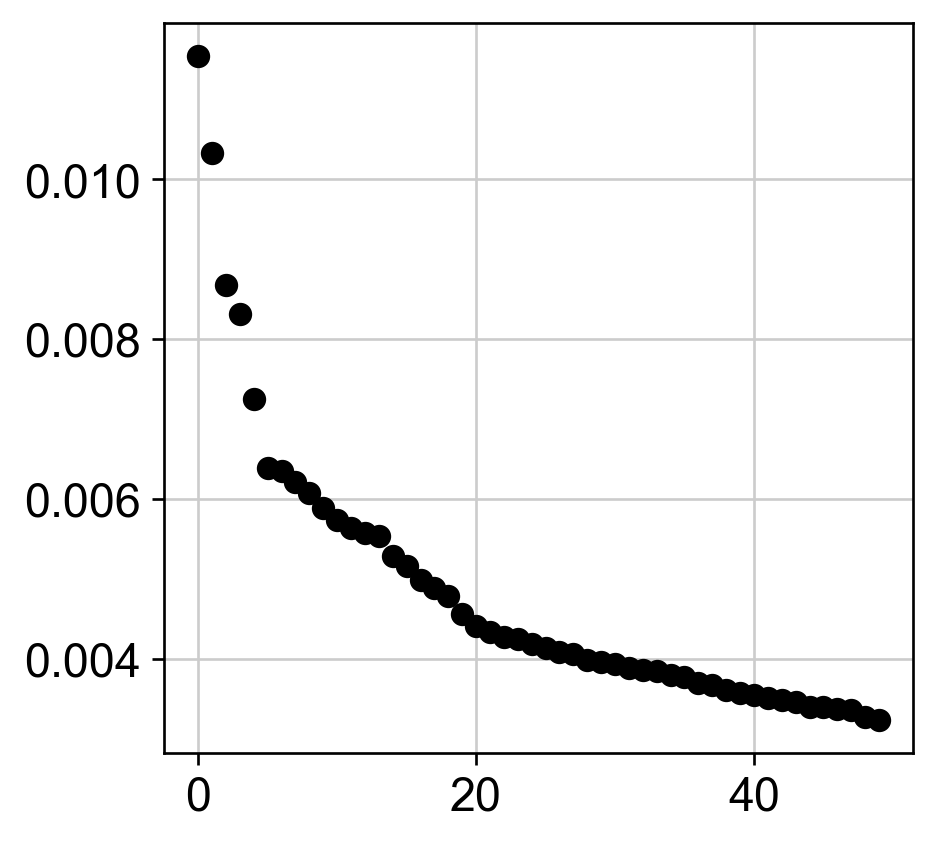

In [148]:
plt.plot(prkcdData.uns["pca"]["variance_ratio"],'ok')

In [149]:
sum(prkcdData.uns["pca"]["variance_ratio"][0:5])

0.04609723296016455

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


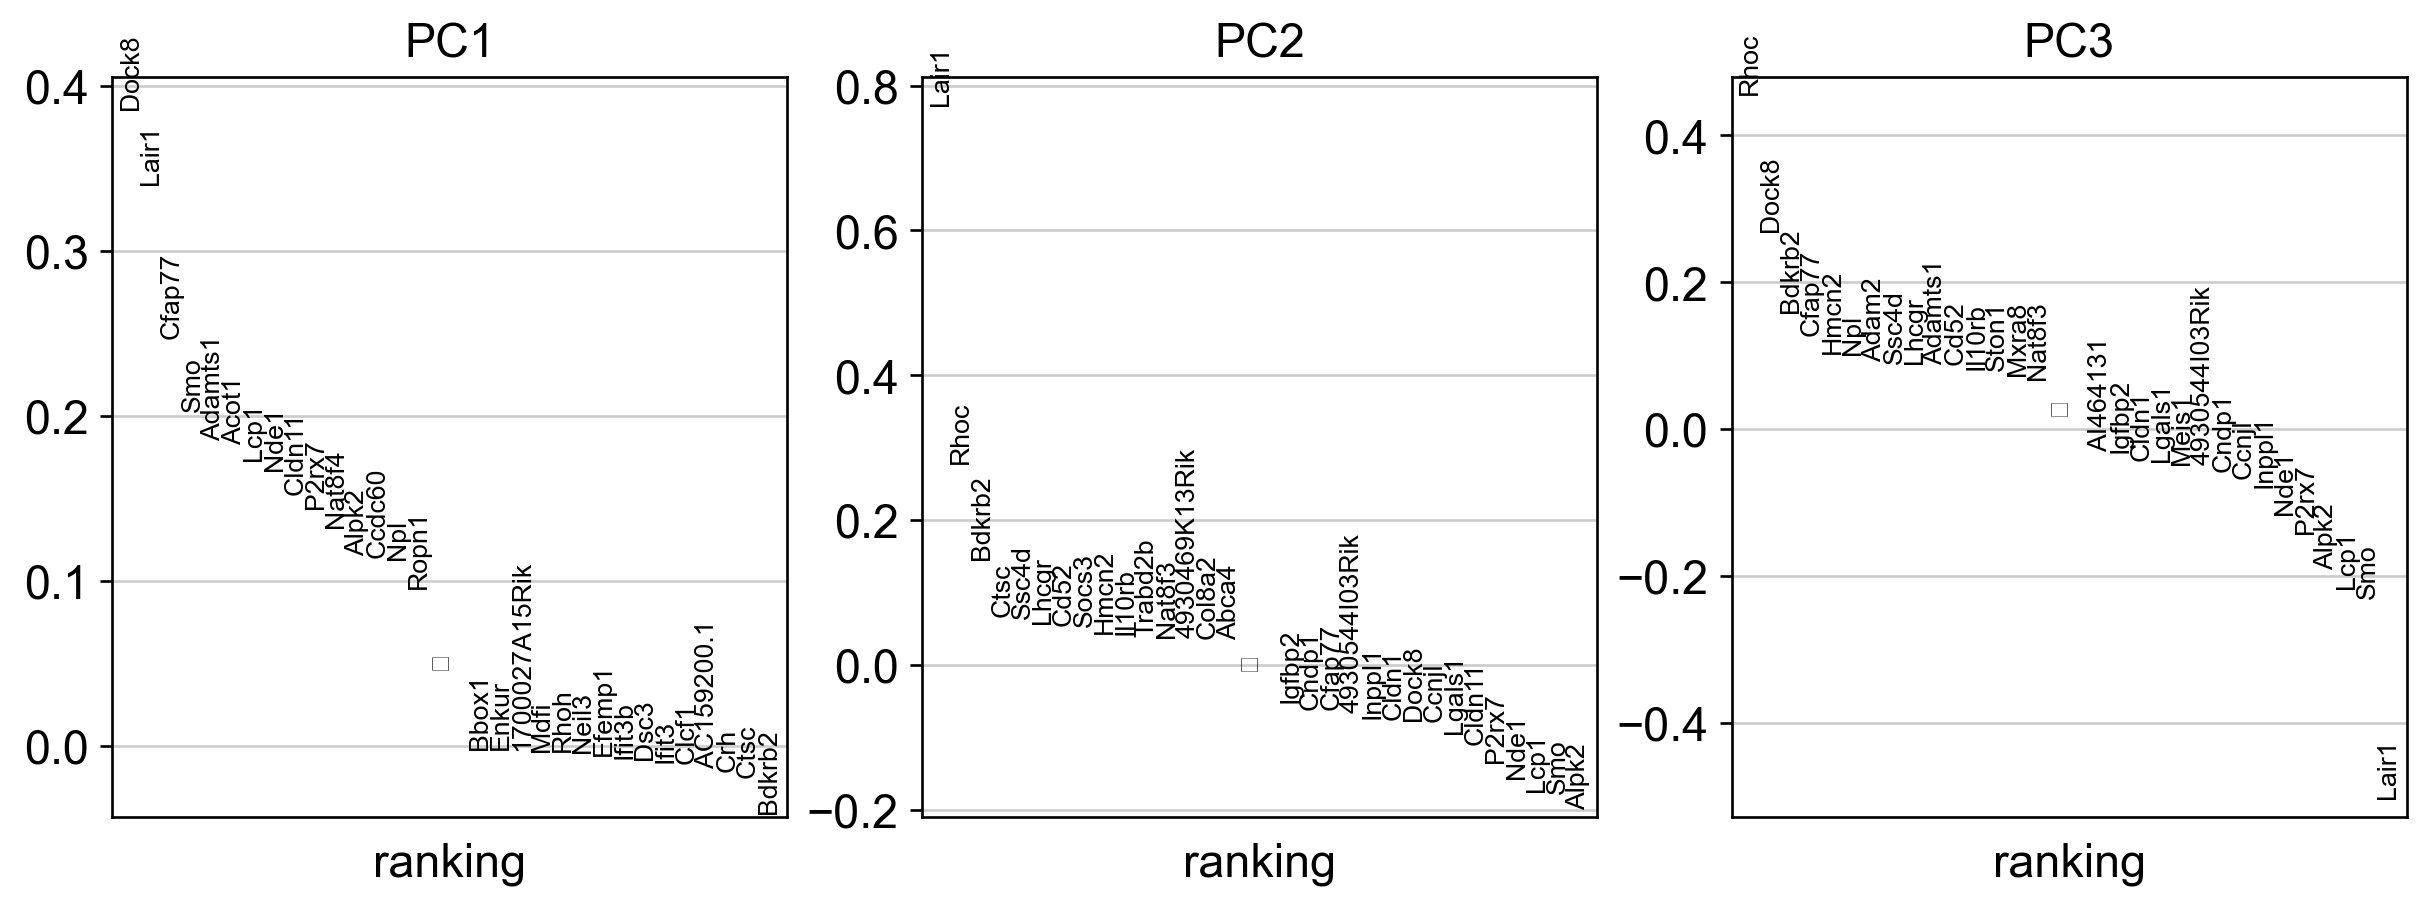

In [124]:
sc.pl.pca_loadings(prkcdData)

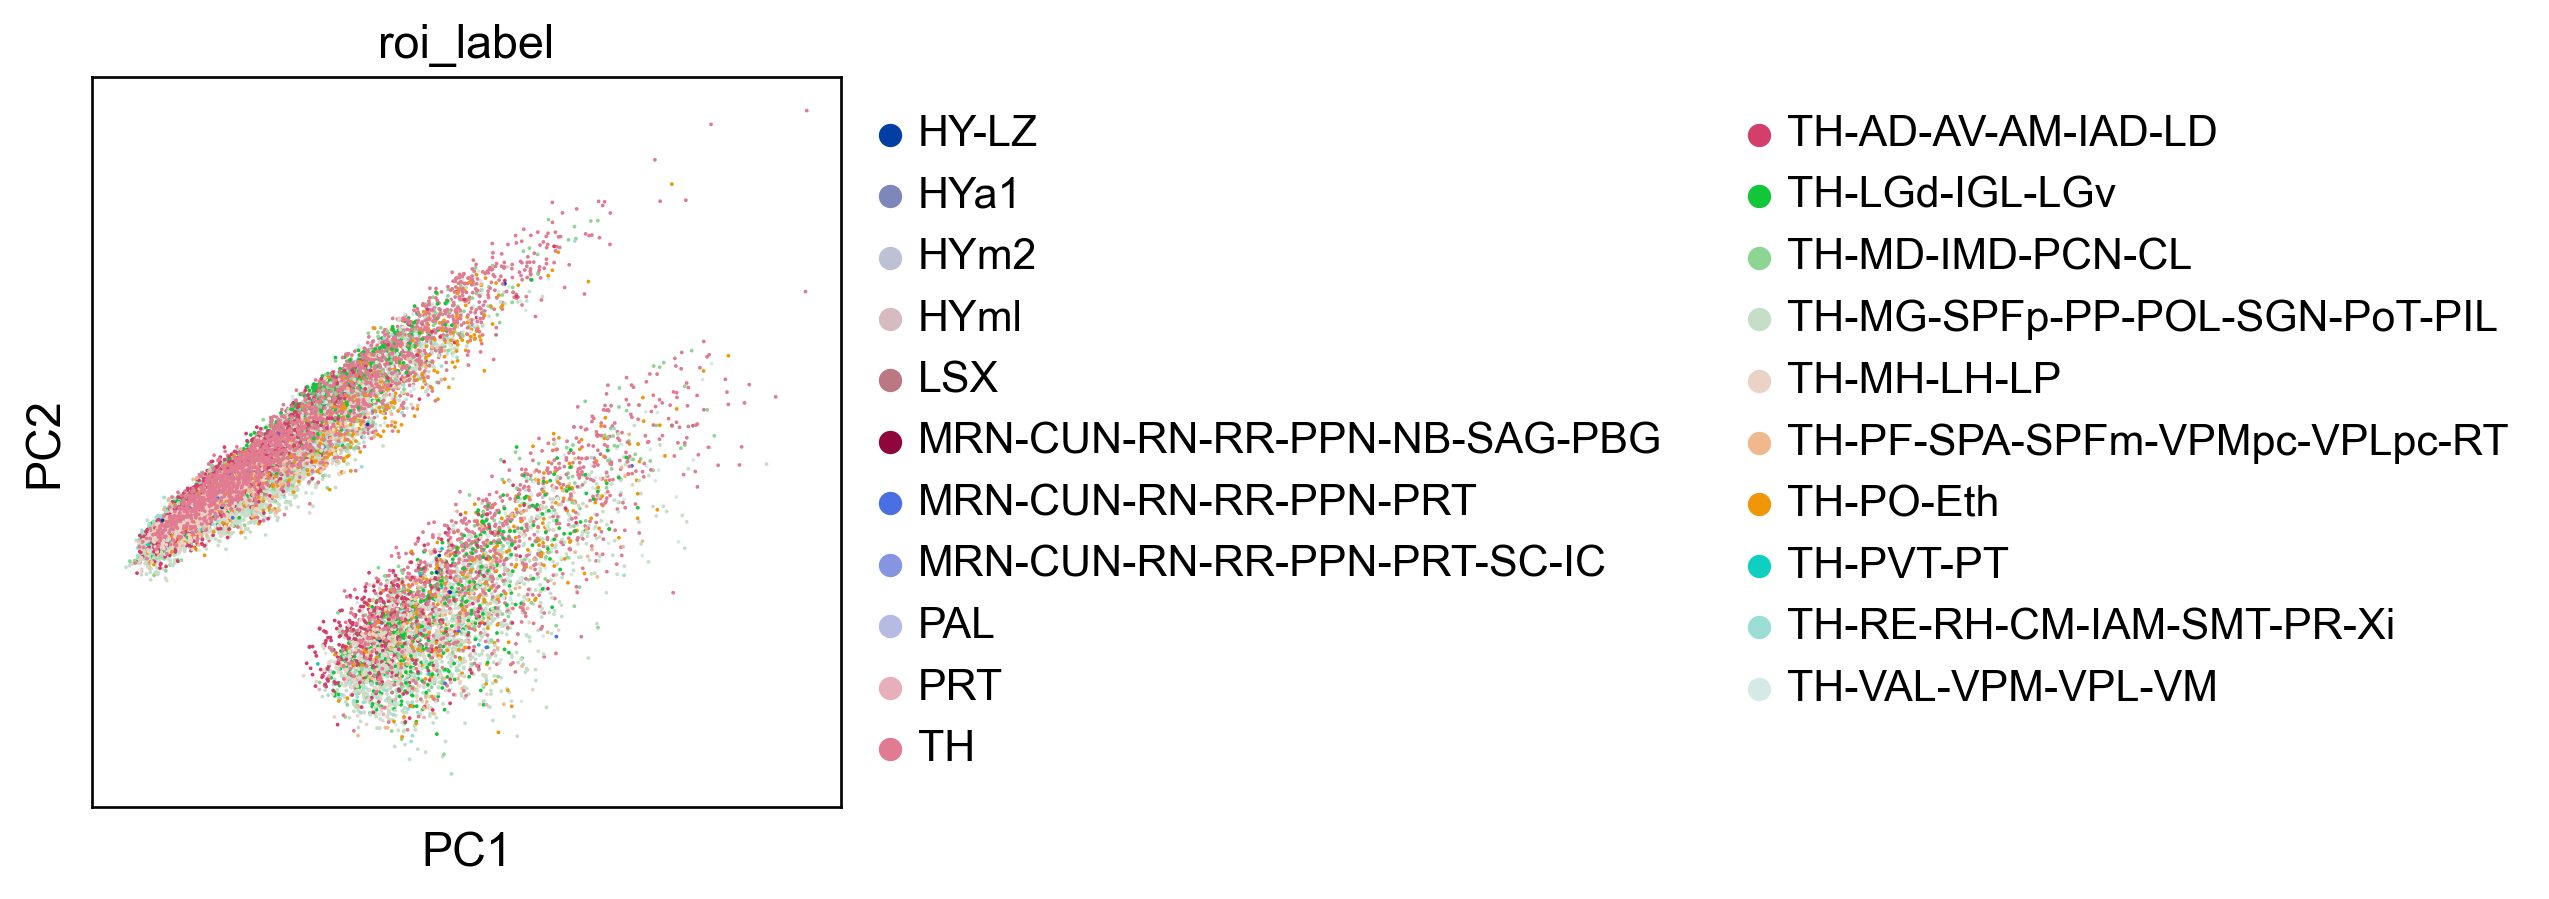

In [150]:
# genes = ["Dock8","Rhoc","Lair1"]
genes = "roi_label"
sc.pl.pca(prkcdData, dimensions = (0,1), color=genes)

In [144]:
prkcdData.obs["roi"].unique()

['TH - MG-SPFp-PP-POL-SGN-PoT-PIL', 'TH - PO-Eth', 'TH - PF-SPA-SPFm-VPMpc-VPLpc-RT', 'TH', 'STR - LSX', ..., 'HY - HYm2', 'MB - PRT', 'MB - MRN-CUN-RN-RR-PPN-PRT', 'MB - MRN-CUN-RN-RR-PPN-NB-SAG-PBG', 'MB - MRN-CUN-RN-RR-PPN-PRT-SC-IC']
Length: 21
Categories (21, object): ['CNU - PAL', 'HY - HYa1', 'HY - HYm2', 'HY - HYml', ..., 'TH - PO-Eth', 'TH - PVT-PT', 'TH - RE-RH-CM-IAM-SMT-PR-Xi', 'TH - VAL-VPM-VPL-VM']

In [205]:
keepIndices = gluCounts[gluCounts.Count > 400].index
keepIndices = list(set(keepIndices) - set(['TH']))
gluCounts.loc[keepIndices]

Count
TH - RE-RH-CM-IAM-SMT-PR-Xi       1460
TH - MG-SPFp-PP-POL-SGN-PoT-PIL   5645
TH - VAL-VPM-VPL-VM               1332
TH - LGd-IGL-LGv                  3110
TH - PO-Eth                       1114
TH - AD-AV-AM-IAD-LD              2482
TH - MH-LH-LP                     1319
TH - PF-SPA-SPFm-VPMpc-VPLpc-RT    458
TH - MD-IMD-PCN-CL                1627

In [216]:
roiData = prkcdData[prkcdData.obs["roi"].isin(keepIndices)]

## Unused

In [548]:
# Use AIBs color maps
groupby = "subclass"
# Grab dataframe with labels and colors for that grouping
colorDF = thData.obs[[groupby + "_label",groupby + "_color"]]
colorDict = {}
# For each label, find color
for group in np.unique(colorDF[groupby + "_label"]):
    colorDict[group] = colorDF[colorDF[groupby + "_label"] == group][groupby + "_color"][0]
# colorDict = dict(zip(thData.obs["cl"],thData.obs["cluster_color"]))

In [543]:
# Try using AIBs color maps but make GABA and NN other colors
groupby = "cl"
# Grab dataframe with labels and colors for that grouping
colorDF = thData.obs[[groupby,groupby + "uster_color"]]
colorDict = {}
# For each label, find color
for group in np.unique(colorDF[groupby]):
    if group in classDict["NN"]:
        colorDict[group] = "lightgray"
    elif group in classDict["Gaba"]:
        colorDict[group] = "dimgray"
    else:
        colorDict[group] = colorDF[colorDF[groupby] == group][groupby + "uster_color"][0]
# colorDict = dict(zip(thData.obs["cl"],thData.obs["cluster_color"]))

In [541]:
# Try using AIBs color maps
groupby = "cl"
# Grab dataframe with labels and colors for that grouping
colorDF = thData.obs[[groupby,groupby + "uster_color"]]
colorDict = {}
# For each label, find color
for group in np.unique(colorDF[groupby]):
    colorDict[group] = colorDF[colorDF[groupby] == group][groupby + "uster_color"][0]
# colorDict = dict(zip(thData.obs["cl"],thData.obs["cluster_color"]))

In [575]:
# Manually specify colormap
NNcolor = "lightgray"
GABAcolor = "dimgray"
colorDict = {'Astro': 'red', 'Endo': 'blue', 'TH/HY Gata3': GABAcolor, 'HY/TH Gnb3': GABAcolor, 
             'TH/HY Pax6': GABAcolor, 'TH Otx2': GABAcolor,'HY Lhx1': GABAcolor,
             'TH Prkcd_Grin2c': 'black', 'TH_Rxfp1_Epb4': 'blue','TH PVT_Ntrk1': 'green', 'TH Tfap2d': 'red',
             'TH PF_Fzd5': 'black', 'TH/HY Gbx2 Zim1': 'black', 'HY Foxa1': 'black',
             'HY Pitx2': 'black', 'TH Pitx2': 'black', 'TH/HY Gbx2 Fmo1': 'black', 'TH/HY Pth2': 'black',
             'TH AV_Col27a1': 'black', 'TH Serpinb7': 'black',
             'TH LH_Pou4f1_Sox1': 'black','TH MH_Tac2': 'black'}

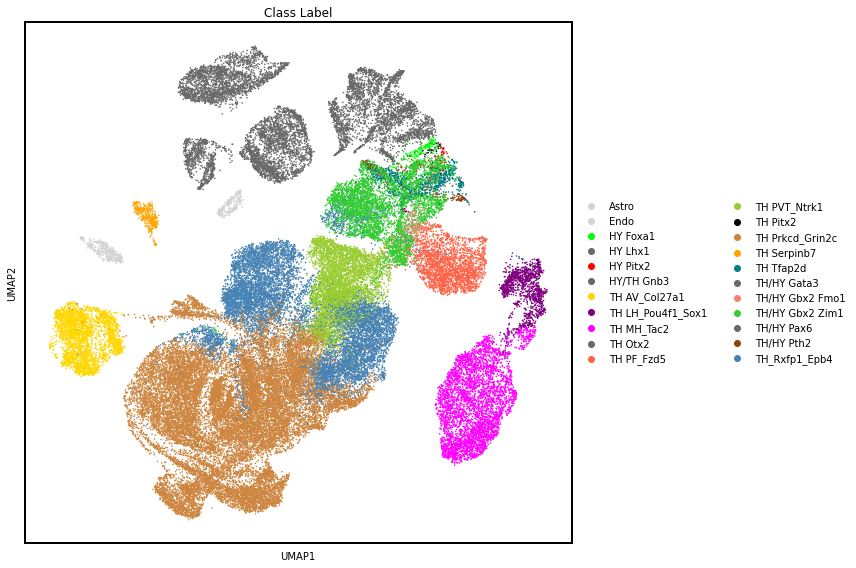

In [197]:
# Class UMAP plot
# sc.tl.umap(thData)
ax = sc.pl.umap(thData, color="subclass_label",palette = colorDict,show=False, size = 10)
ax.figure.set_size_inches(12,8)
plt.tight_layout()
# ax.set_rasterized(True)
# plt.xlabel('UMAP1', fontsize=16)
# plt.ylabel('UMAP2', fontsize=16)
plt.title('Class Label')
plt.setp(ax.spines.values(), linewidth=2);
# # plt.legend(["","Gaba","Glut","NN"],fontsize=16)
# plt.savefig("../Figures/Panels/Class_UMAP.pdf", dpi=120, transparent=True)

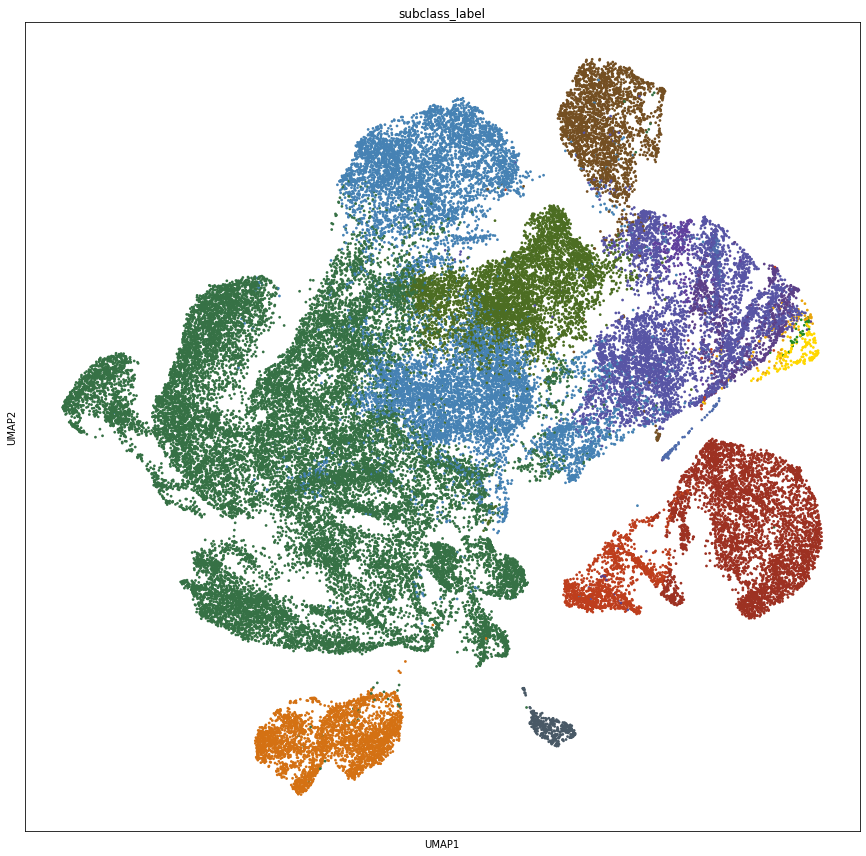

In [387]:
# Calculate umap on glutamatergic data exclusively
# gluData = thData[thData.obs["class_label"] == "Glut"]
# sc.tl.umap(gluData,spread = 3, min_dist = .6)
# ax = sc.pl.umap(gluData,color="subclass_label",palette = colorDict, show=False,size=10)
ax = sc.pl.umap(gluData,color="subclass_label", palette=sns.blend_palette(rgb, n_colors=15), show=False,size=30)
#                add_outline= True, outline_width = (.4,.1))
ax.figure.set_size_inches(16,12)
plt.tight_layout()
ax.get_legend().remove()

In [ ]:
ax.data_r

In [15]:
ax.properties()

{'adjustable': 'box',
 'agg_filter': None,
 'alpha': None,
 'anchor': 'C',
 'animated': False,
 'aspect': 'auto',
 'autoscale_on': True,
 'autoscalex_on': True,
 'autoscaley_on': True,
 'axes_locator': None,
 'axisbelow': 'line',
 'box_aspect': None,
 'children': [<matplotlib.collections.PathCollection at 0x1c17c94c490>,
  Text(0.5, 1.0, 'Class Label'),
  Text(0.0, 1.0, ''),
  Text(1.0, 1.0, ''),
 'clip_box': None,
 'clip_on': True,
 'clip_path': None,
 'data_ratio': 1.026921504088352,
 'default_bbox_extra_artists': [<matplotlib.collections.PathCollection at 0x1c17c94c490>,
 'facecolor': (1.0, 1.0, 1.0, 1.0),
 'figure': <Figure size 864x576 with 1 Axes>,
 'frame_on': True,
 'geometry': (1, 1, 1),
 'gid': None,
 'gridspec': GridSpec(1, 1),
 'images': <a list of 0 AxesImage objects>,
 'in_layout': True,
 'label': '',
 'legend': <matplotlib.legend.Legend at 0x1c17d74e170>,
 'legend_handles_labels': ([<matplotlib.collections.PathCollection at 0x1c17d7bbd30>,
  ['Gaba', 'Glut', 'NN']),
 'li